### PyTorch Computer vision

*  `torchvision` - base domain library for pytorch computer vision
*  `torchvision.datasets` - get datasets and data loading methods
*  `torchvision.models` - get pretrained models
*  `torchvision.transforms` - methods for manipulating vision data
*  `torch.utils.data.Dataset` Base dataset class for PyTorch
*  `torch.utils.data.DataLoader` - created python iterable over a dataset

### Computer Vision Libraries in Pytorch

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#Import matplotlib
import matplotlib.pyplot as plt

* `ToTensor()` converts a `PIL Image` or `numpy.ndarray` to tensor.

In [2]:
# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.1


### Dataset

Load Fashion MNIST dataset from `torchvision.datasets`.

In [3]:
train_data = datasets.FashionMNIST(
    root = 'data', # where to download the data
    train = True, # Training data
    download = True, # Do we want to download?
    transform = ToTensor(), # Apply transform to train data
    target_transform = None  # Label transform
)

test_data = datasets.FashionMNIST(
    root = 'data', # where to download the data
    train = False, # Training data
    download = True, # Do we want to download?
    transform = ToTensor(), # Apply transform to test data
    target_transform = None  # Label transform
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15763399.64it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271107.83it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5046954.93it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15227275.73it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, label = train_data[0]

In [6]:
image.shape

torch.Size([1, 28, 28])

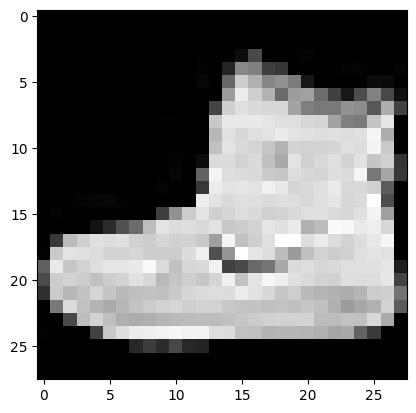

In [7]:
plt.imshow(image.reshape(28, 28), cmap = 'gray')

In [8]:
label

9

In [9]:
class_names = train_data.classes
class_names[9]

'Ankle boot'

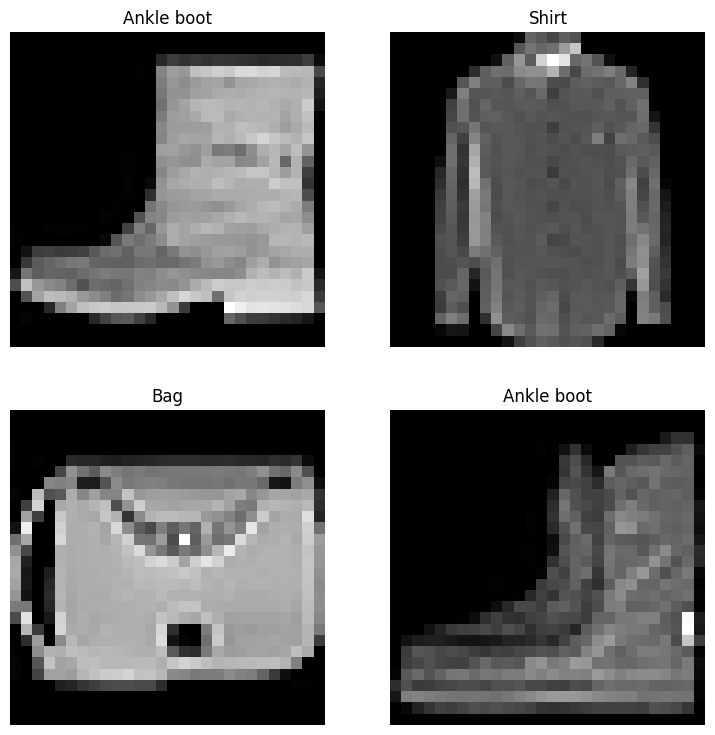

In [10]:
# Plot images
torch.manual_seed(42)

fig = plt.figure(figsize = (9, 9))
rows, cols = 2, 2
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(class_names[label])
  plt.axis(False)

### DataLoader

In [11]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = 32,
                              shuffle = True)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 32,
    shuffle = False
)

In [12]:
train_dataloader

In [13]:
test_dataloader

In [14]:
print(f"DataLoaders : {train_dataloader, test_dataloader}")
print(f"Length : {len(train_dataloader)} batches of 32")

DataLoaders : (<torch.utils.data.dataloader.DataLoader object at 0x7e13ec4bbd00>, <torch.utils.data.dataloader.DataLoader object at 0x7e13ec4bbeb0>)
Length : 1875 batches of 32


In [15]:
# Check train_dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Shape : torch.Size([1, 28, 28])


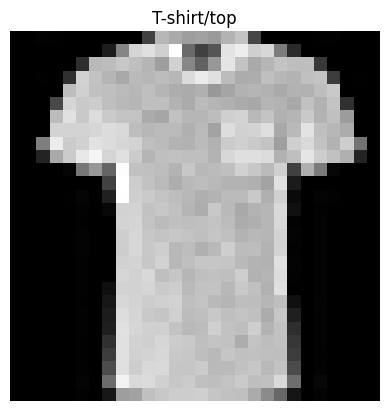

In [16]:
# Visualiz a batch
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image Shape : {img.shape}")

### Create a Baseline Model

A baseline model is a simple model we build initially and will try to improve upon with subsequent experiments.

In [17]:
# Create a Baseline model
from torch import nn

class FashionMNISTModelV0(nn.Module):

  # Constructor
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features=hidden_units, out_features = output_shape)
    )

    # Activation
  def forward(self, x):
      return self.layer_stack(x)

In [18]:
torch.manual_seed(42)

# Setup model
model_0 = FashionMNISTModelV0(
    input_shape = 784,
    hidden_units = 10,
    output_shape = 10
).to("cpu")

In [19]:
dummy_x = torch.rand([1, 784])
dummy_y = model_0(dummy_x)
dummy_y

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### Setting up the training

Setting up loss, optimizer and evaluation metrics

In [20]:
import requests
from pathlib import Path

# Download helper functions from LearnPyTorch repo
if Path("helper_functions.py").is_file():
  print("Helper function exists already")
else:
  print("Downloading helper_functions.py......")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [21]:
# Import accuracy metrics from helper_functions
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [22]:
from timeit import default_timer as timer

def print_train_time(start:float, end:float):
  total_time = end - start
  print(f"Train time is {total_time} seconds")

### Training

In [23]:
from tqdm.auto import tqdm

In [24]:
import time

# Set the seed and start the timer
torch.manual_seed(42)
start = time.time()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
end = time.time()
total_train_time_model_0 = end - start
print(f"Total time : {total_train_time_model_0} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Total time : 29.26467537879944 seconds


### Evaluate the model

In [25]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """ Returns a dictionary containing the results of model predicting on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim = 1))
    
    loss /= len(data_loader)
    acc /= len(data_loader)
  
  return{"model_name": model.__class__.__name__,
         "model_loss" : loss.item(),
         "model_acc":acc}

In [26]:
model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [27]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

### Setup device agnostic code

In [28]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Building model with non-linearity

In [29]:
class FashionMNISTModelV1(torch.nn.Module):
    
    # Constructor
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
        )
        
    def forward(self, x):
        return(self.layer_stack(x))

Set up model.

In [30]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device 

device(type='cuda', index=0)

### Setting up loss evaluation and accuracy metrics

In [31]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

### Functionizing train and test loop

In [32]:
# Training function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [33]:
# Test function
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Training the model

In [34]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time is 33.15552641900001 seconds


### Evaluation function

Let's now update the evaluation function and use the `device` parameter as we want both our inputs and outputs to be in same device. GPU in this case.

In [35]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


Now, calculate the model_1 result.

In [36]:
# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [37]:
# Check baseline results
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

Woah, in this case, it looks like adding non-linearities to our model made it perform worse than the baseline.

That's a thing to note in machine learning, sometimes the thing we thought should work doesn't.

And then the thing we thought might not work does.

It's part science, part art.

From the looks of things, it seems like our model is overfitting on the training data.

Overfitting means our model is learning the training data well but those patterns aren't generalizing to the testing data.

Two of the main to fix overfitting include:

* Using a smaller or different model (some models fit certain kinds of data better than others).
* Using a larger dataset (the more data, the more chance a model has to learn generalizable patterns).

### Using CNNs

In [38]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [39]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [40]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

### Training and Testing

In [41]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59671 | Train accuracy: 78.25%
Test loss: 0.39706 | Test accuracy: 85.51%

Epoch: 1
---------
Train loss: 0.35913 | Train accuracy: 87.10%
Test loss: 0.35853 | Test accuracy: 86.72%

Epoch: 2
---------
Train loss: 0.32398 | Train accuracy: 88.22%
Test loss: 0.32666 | Test accuracy: 88.30%

Train time is 41.36582576700005 seconds


In [42]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32665765285491943,
 'model_acc': 88.29872204472844}

### Comparing the all 3 models

In [43]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.326658,88.298722


In [44]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,29.264675
1,FashionMNISTModelV1,0.685001,75.019968,NaN
2,FashionMNISTModelV2,0.326658,88.298722,NaN


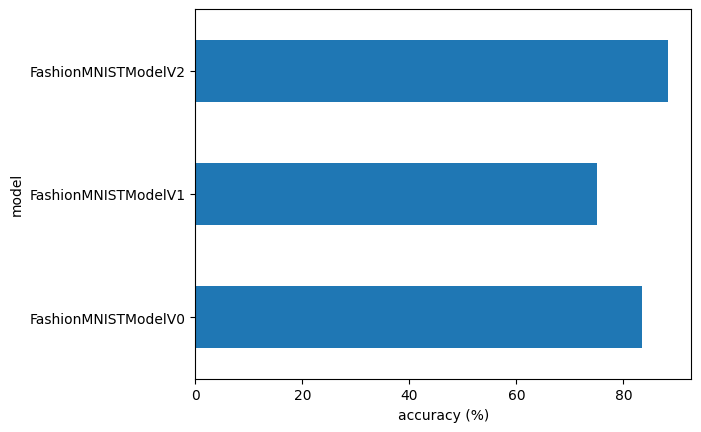

In [45]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

### Making Predictions

In [46]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [51]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels} ({class_names[test_labels[0]]}")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: [5, 1, 7, 4, 3, 0, 4, 7, 1] (Sandal


In [52]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[6.9182e-08, 5.4248e-08, 8.3908e-08, 3.0590e-07, 9.8501e-09, 9.9954e-01,
         1.0094e-06, 1.3245e-05, 2.8354e-05, 4.1911e-04],
        [3.4255e-02, 3.6445e-01, 1.3759e-02, 3.8511e-01, 8.4223e-02, 2.9319e-04,
         1.1694e-01, 4.2483e-04, 3.1084e-04, 2.3151e-04]])

In [53]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 3, 7, 4, 3, 0, 4, 7, 1])

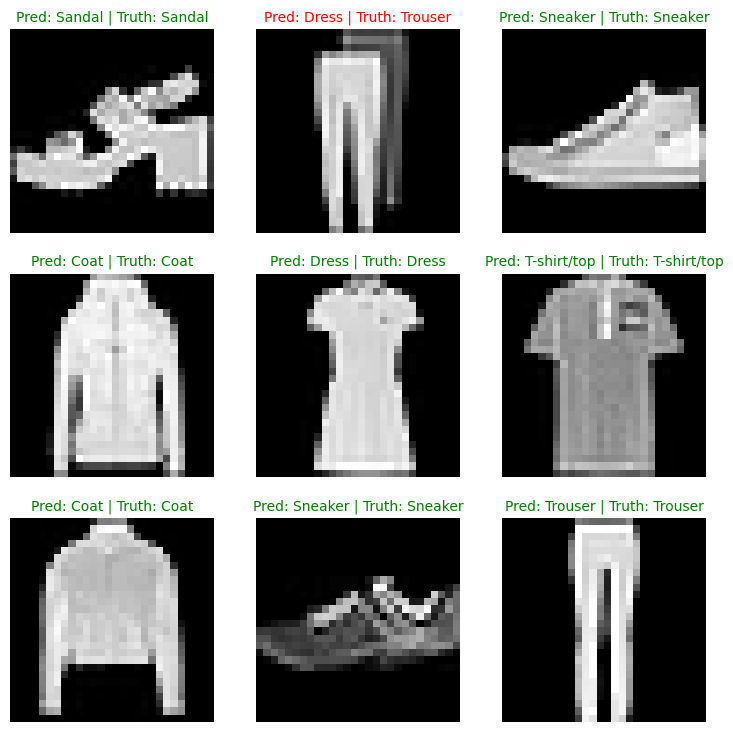

In [54]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

### Create confusion matrix

In [55]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [56]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


mlxtend version: 0.22.0


In [57]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


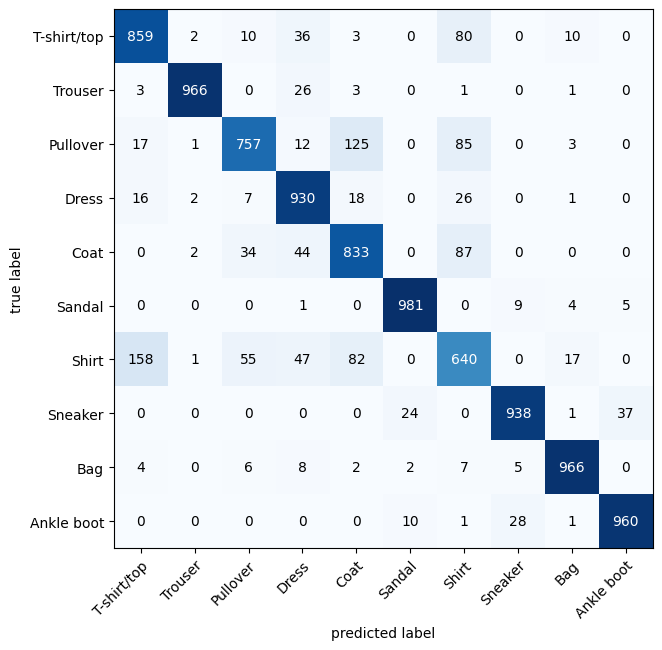

In [58]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

### Save the best performing model

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_first_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)